In [1]:
from utils import *

In [27]:
points_msg=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",PointCloud2,timeout=5)
points_data = ros_numpy.numpify(points_msg)    
image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
image = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
    #hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV_FULL)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print (image.shape)

(480, 640, 3)


In [28]:
_,corrected=correct_points(points_msg)


############head [ 9.86125239 -1.44793807  1.10333083] [ 0.90230508 -0.01522867  0.00727029 -0.43076765]


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline


In [30]:
corrected['z'].shape

(480, 640)

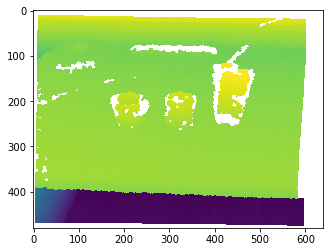

In [31]:
plt.imshow(corrected['z'])

In [32]:
zs_no_nans=np.zeros((corrected['z'].shape))
for i in range(corrected['z'].shape[0]):
    for j in range(corrected['z'].shape[1]):
        if np.isnan(corrected['z'][i,j]):
            zs_no_nans[i,j]=1.0
            #print ('reject')
        else:
            zs_no_nans[i,j]=corrected['z'][i,j]

In [33]:
zs_no_nans

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

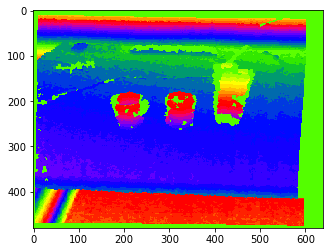

In [34]:
plt.imshow(zs_no_nans, cmap='prism')

In [35]:
zs_no_nans[300,300]

-0.41110527515411377

In [36]:
histogram, bin_edges =(np.histogram(zs_no_nans, bins=50))

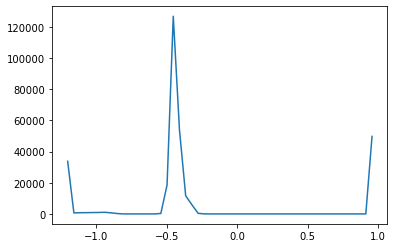

In [37]:
plt.plot(bin_edges[0:-1], histogram)  

In [38]:
histogram[:-1].argmax(), bin_edges[histogram[:-1].argmax()]

(17, -0.45283543586730957)

In [39]:
bin_edges[17:19]

array([-0.45283544, -0.40881012])

In [40]:
t = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
trans=t.transform.translation.z

In [41]:
img_corrected = np.where((-zs_no_nans < trans*0.99) ,zs_no_nans,5.0)  #FLOOR


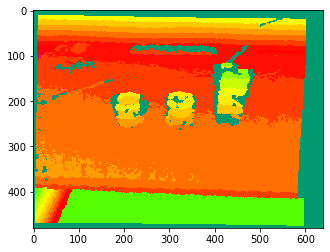

In [42]:
plt.imshow(img_corrected, cmap='prism')

In [18]:
img_corrected[300,30], zs_no_nans[300,30]

(-0.4045797884464264, -0.4045797884464264)

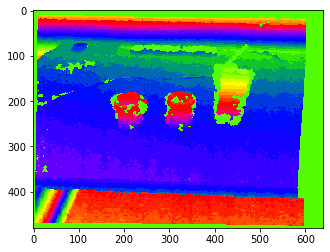

In [19]:
plt.imshow(zs_no_nans, cmap='prism')

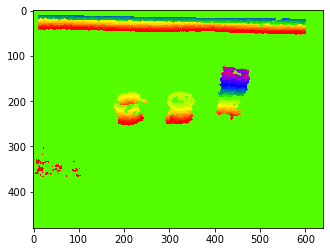

In [20]:
img_corrected = np.where(    (-zs_no_nans <  (trans*0.999)-0.705  )                        ,zs_no_nans,1)

plt.imshow(img_corrected, cmap='prism')

In [21]:
img_corrected[100,600],img_corrected[100,300]

(1.0, 1.0)

In [22]:
img_corrected[300,300], zs_no_nans[300,300]

(1.0, -0.4103802442550659)

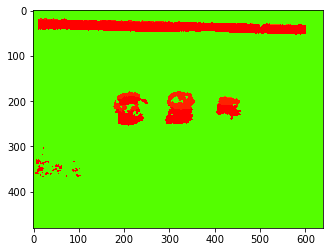

In [23]:
#table1#img_corrected_top = np.where(    (-img_corrected >  (trans*0.999)-0.751  )                        ,img_corrected,1)
img_corrected_top = np.where(    (-img_corrected >  (trans*0.999)-0.77 )                        ,img_corrected,5)

plt.imshow(img_corrected_top, cmap='prism')

In [24]:
img_corrected[300,300], zs_no_nans[300,300]

(1.0, -0.4103802442550659)

In [25]:
(trans*0.999)-0.751

0.35122692772652353

In [52]:
lower=100
higher=200000
reg_ly= 30
reg_hy=600
contours, hierarchy = cv2.findContours(img_corrected.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
i=0
cents=[]
points=[]
images=[]
for i, contour in enumerate(contours):

    area = cv2.contourArea(contour)
    if area > lower and area < higher :
        M = cv2.moments(contour)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        if (cY > reg_ly and cY < reg_hy  ):

                boundRect = cv2.boundingRect(contour)
                #just for drawing rect, dont waste too much time on this
                #image_aux= iimmg[boundRect[1]:boundRect[1]+max(boundRect[2],boundRect[3]),boundRect[0]:boundRect[0]+max(boundRect[2],boundRect[3])]
                

                image_aux= image[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[1]+boundRect[2]]
                images.append(image_aux)
                image_aux= img_corrected[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]

                mask=np.where(image_aux!=5)
                npmask=np.asarray(mask).T
                hsv_image=cv2.rectangle(hsv_image,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
                cv2.circle(hsv_image, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(hsv_image, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY,'len mask',len(npmask))
                

cX,cY 14 351 len mask 399
cX,cY 14 335 len mask 399
cX,cY 324 215 len mask 5100
cX,cY 317 197 len mask 493
cX,cY 210 217 len mask 5070
cX,cY 439 181 len mask 8932
cX,cY 427 121 len mask 486
cX,cY 307 31 len mask 26180


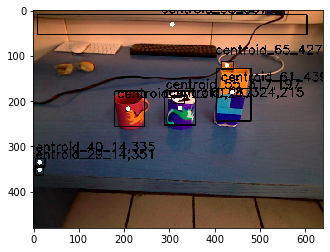

In [54]:
plt.imshow(hsv_image)